# Semi-empirical rudder

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_simplified import vmm
#from vessel_manoeuvring_models.models.vmm_abkowitz_expanded import abkowitz_model_expanded as vmm

from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.regression import Regression
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.symbols import *
from vessel_manoeuvring_models.parameters import df_parameters
from vessel_manoeuvring_models.prime_system import PrimeSystem
from wPCC_pipeline.pipelines.vct_data.nodes import vct_scaling
p = df_parameters['symbol']
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.substitute_dynamic_symbols import lambdify, run
import statsmodels.api as sm
import seaborn as sns
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import *
import matplotlib.pyplot as plt
plt.style.use('bmh')
from copy import deepcopy

#from vct.bokeh_plotting import create_tab

## Load VCT data:

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
df_VCT = catalog.load(f"{ship}.df_VCT")
ship_data = catalog.load(f"{ship}.ship_data")
df_VCT = vct_scaling(data=df_VCT, ship_data=ship_data)
df_VCT['U'] = df_VCT['V']
df_VCT['fy_rudders']*=2  #(There seems to be onlu one rudder counted before)

mask = df_VCT['model_name'].isin([
    'V2_3_R2',
])
df_VCT = df_VCT.loc[mask].copy()

thrust_keys = catalog.load(f"params:{ship}.thrust_keys")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[06/01/23 08:24:13] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=181149;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=112370;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/01/23 08:24:13] INFO     Kedro project phd                                                      ]8;id=340757;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=155953;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=721872;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=328782;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=459865;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=433690;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=876676;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=692813;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=958338;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=58843;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=669029;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=670984;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.thrust_keys' (MemoryDataSet)...     ]8;id=599194;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=884782;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=94545;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=632164;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=294698;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=25039;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

## Rudder lift

In [4]:
eq_L

Eq(L, A_R*C_L*C_L_tune*V_R**2*rho/2)

where $A_R$ is the rudder area, $V_R$ is the flow velocity at the rudder.

In [5]:
eq_C_L

Eq(C_L, 2*pi*Lambda*(Lambda + 1)*sin(delta + gamma*kappa)/(Lambda + 2)**2)

where $\Lambda$ is the aspect ratio, $\delta$ is rudder angle. $\gamma$ is the angle of the flow velocity ($V_R$), induced by the drift angle and yaw rate, given by,

In [6]:
eq_gamma

Eq(gamma, atan(V_yr/V_xr))

$V_R$ is divided into components in the x,y, and z direction:

In [7]:
eq_V_R

Eq(V_R, sqrt(V_xr**2 + V_yr**2 + V_zr**2))

Where the x y, and z components are given by the following three equations,

In [8]:
eq_V_xR

Eq(V_xr, V_x + q*z_R - r*y_R)

In [9]:
eq_V_yR

Eq(V_yr, p*z_R - r*x_R - v)

In [10]:
eq_V_zR

Eq(V_zr, -q*x_R - q*y_R - w)

But for a three degree of freedom (dof) model,

In [11]:
eq_V_xR_3dof = eq_V_xR.subs([
(p,0),
(q,0),
(w,0),
])
eq_V_xR_3dof


Eq(V_xr, V_x - r*y_R)

In [12]:
eq_V_yR_3dof = eq_V_yR.subs([
(p,0),
(q,0),
(w,0),
])
eq_V_yR_3dof

Eq(V_yr, -r*x_R - v)

In [13]:
eq_V_zR_3dof = eq_V_zR.subs([
(q,0),
(w,0),
])
eq_V_zR_3dof

Eq(V_zr, 0)

The so-called flow straightening effect of a hull is modelled by a factor $\kappa$.

The aspect ratio $\Lambda$ depends on the rudder angle, which can be modelled as,

In [14]:
eq_Lambda

Eq(Lambda, Lambda_g*(2 - Abs(delta/delta_lim)))

where $\Lambda_g$ is the geometric aspect ratio, given by 

In [15]:
eq_Lambda_g

Eq(Lambda_g, b_R**2/A_R)

In [16]:
eqs = [
eq_L,
eq_C_L,
eq_Lambda,
eq_Lambda_g,
eq_V_R,
eq_V_xR_3dof,
eq_V_yR_3dof,
eq_V_zR_3dof,
eq_gamma,
]
solution_lift = sp.solve(eqs, L, C_L, Lambda, Lambda_g, V_R, V_xR, V_yR, V_zR, gamma, dict=True)[0]
solution_lift[L]

pi*A_R*C_L_tune*b_R**2*rho*((V_x - r*y_R)**2 + (r*x_R + v)**2)*(-A_R*Abs(delta/delta_lim) + 2*A_R + b_R**2*Abs(delta/delta_lim)**2 - 4*b_R**2*Abs(delta/delta_lim) + 4*b_R**2)*sin(delta - kappa*atan((r*x_R + v)/(V_x - r*y_R)))/(2*A_R - b_R**2*Abs(delta/delta_lim) + 2*b_R**2)**2

In [17]:
solution_lift.keys()

dict_keys([C_L, L, Lambda, Lambda_g, V_R, V_xr, V_yr, V_zr, gamma])

### No propeller

In [18]:
eq_V_x_no_propeller = sp.Eq(V_x,u)
eq_V_x_no_propeller

Eq(V_x, u)

In [19]:
solution_no_propeller = deepcopy(solution_lift)

In [20]:
solution_no_propeller[L] = sp.simplify(solution_lift[L].subs(V_x,eq_V_x_no_propeller.rhs))

In [21]:
solution_no_propeller[L]

pi*A_R*C_L_tune*b_R**2*rho*((r*x_R + v)**2 + (r*y_R - u)**2)*(-A_R*Abs(delta/delta_lim) + 2*A_R + b_R**2*Abs(delta/delta_lim)**2 - 4*b_R**2*Abs(delta/delta_lim) + 4*b_R**2)*sin(delta + kappa*atan((r*x_R + v)/(r*y_R - u)))/(2*A_R - b_R**2*Abs(delta/delta_lim) + 2*b_R**2)**2

In [22]:
solution_no_propeller[Y_R] = sp.Eq(Y_R, n_prop*solution_no_propeller[L]).rhs

In [23]:
lambdas_no_propeller={key:lambdify(expression) for key,expression in solution_no_propeller.items()}

In [24]:
lambdas_no_propeller[Y_R]

<function _lambdifygenerated(A_R, C_L_tune, b_R, delta, delta_lim, kappa, n_prop, r, rho, u, v, x_R, y_R)>

#### Test the function

In [25]:
rudder_particulars = {
'x_R' : ship_data['x_r'],
'y_R' : 0,
'z_R' : 0,
'A_R' : 70/(ship_data['scale_factor']**2),
'b_R'  : 7.18/ship_data['scale_factor'],
'n_prop':ship_data['n_prop'],
}

In [26]:
df_rudder = df_VCT.groupby('test type').get_group('Rudder angle').copy()
df_rudder.sort_values(by=['V','delta'], inplace=True)
rudder_parameters = {
"C_L_tune" : 1.0,
"delta_lim": np.deg2rad(35),
"kappa": 0.5, # (Small value means much flow straightening)
}

prediction = df_rudder.copy()
prediction['fy_rudders'] = run(function=lambdas_no_propeller[Y_R], inputs=df_rudder, **rudder_particulars, **rudder_parameters)


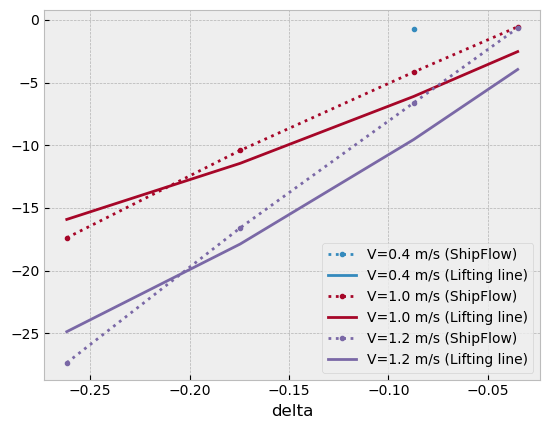

In [27]:
fig,ax=plt.subplots()
prediction_groups = prediction.groupby(by='V', sort=False)
key='fy_rudders'
for V_, group in df_rudder.groupby(by='V', sort=False):
    plot = group.plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (ShipFlow)', style='.:', ax=ax)
    color = plot.lines[-1].get_color()
    prediction_groups.get_group(V_).plot(x='delta', y=key, label=f'V={np.round(V_,1)} m/s (Lifting line)', color=color, style='-', ax=ax)


# Adding propeller influence

The flow to the rudder behind a working propeller is influenced by the propeller race. In the model presented below, only the influence on the flow in the x direction is included. The velocity induced by the propeller, is modelled with an ideal propulsor model in potential flow, so that the velocity at the rudder can be expressed as,  

In [29]:
eq_V_x

Eq(V_x, V_inf*r_inf**2/r_p**2)

where $V_{inf}$ is the axial flow velocity far downstream of the propeller, which can be calculated from the thrust coefficient $C_{Th}$,

In [30]:
eq_V_inf

Eq(V_inf, V_A*sqrt(C_Th + 1))

where the advance velocity $V_A$ is the velocity in the wake of the ship and $C_{Th}$ is the thrust coefficient,

In [31]:
eq_V_A

Eq(V_A, u*(1 - w_f))

In [32]:
eq_C_Th

Eq(C_Th, 2*T/(pi*V_A**2*r_0**2*rho))

$r_{inf}$ is the he radius of the slipstream far behind the propeller which is calculated as,

In [33]:
eq_r_inf

Eq(r_inf, r_0*sqrt(V_A/(2*V_inf) + 1/2))

where $r_0$ is the propeller radius.

Since there the rudder is not positioned right on the propeller disk, this means that the axial distance between the propeller and the rudder should be accounted for. The radius of the propeller slip stream $r_p$ at a downstream distance $x$ between the propeller and rudder can be estimated by,

In [34]:
eq_r

Eq(r_p, r_0*(r_inf*(x/r_0)**1.5/r_0 + 0.14*r_inf**3/r_0**3)/((x/r_0)**1.5 + 0.002744*r_inf**3/r_0**3))

Turbulent mixing of the water jet and surrounding flow increases the radius of the slipstream by $\Delta r$, so that a corrected $V_x$, $V_xcorr$ can be expressed as,

In [35]:
eq_V_x_corr

Eq(V_xcorr, V_A + r_p*(-V_A + V_x)/(r_Delta + r_p))

In [36]:
eq_r_Delta

Eq(r_Delta, 0.15*x*(-V_A + V_x)/(V_A + V_x))

In [37]:
eq_r_Delta

Eq(r_Delta, 0.15*x*(-V_A + V_x)/(V_A + V_x))

In [38]:
eqs = [
eq_V_x,
eq_r,
eq_r_inf,
]
solution_propeller = sp.solve(eqs,  V_x, r_p, r_inf, dict=True)[0]
solution_propeller[V_x] = sp.simplify(solution_propeller[V_x].subs(V_inf, eq_V_inf.rhs))

In [39]:
solution_propeller[V_x] = sp.simplify(solution_propeller[V_x].subs([
(C_Th, eq_C_Th.rhs),
]))

In [40]:
solution_propeller[V_x] = solution_propeller[V_x].subs([
(V_A, eq_V_A.rhs),
])


In [46]:
solution_propeller[V_xcorr] = sp.simplify(eq_V_x_corr.subs([
(r_Delta, eq_r_Delta.rhs),
(r_p, eq_r.rhs),
(r_inf, solution_propeller[r_inf]),
(V_inf, eq_V_inf.rhs),
(C_Th, eq_C_Th.rhs),
#(V_x, solution_propeller[V_x]),
]))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 solution_propeller[V_xcorr] = sp.simplify(eq_V_x_corr.subs([                                 │
│   2 (r_Delta, eq_r_Delta.rhs),                                                                   │
│   3 (r_p, eq_r.rhs),                                                                             │
│   4 (r_inf, solution_propeller[r_inf]),                                                          │
│                                                                                                  │
│ /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/sympy/simplify/simplify.py:601 in      │
│ simplify                                                                                         │
│                                                                                                  │
│    598 │                                                                                         │
│    599 │   _eval_simplify = getattr(expr, '_eval_simplify', None)                                │
│    600 │   if _eval_simplify is not None:                                                        │
│ ❱  601 │   │   return _eval_simplify(**kwargs)                                                   │
│    602 │                                                                                         │
│    603 │   original_expr = expr = collect_abs(signsimp(expr))                                    │
│    604                                                                                           │
│                                                                                                  │
│ /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/sympy/core/relational.py:691 in        │
│ _eval_simplify                                                                                   │
│                                                                                                  │
│    688 │                                                                                         │
│    689 │   def _eval_simplify(self, **kwargs):                                                   │
│    690 │   │   # standard simplify                                                               │
│ ❱  691 │   │   e = super()._eval_simplify(**kwargs)                                              │
│    692 │   │   if not isinstance(e, Equality):                                                   │
│    693 │   │   │   return e                                                                      │
│    694 │   │   from .expr import Expr                                                            │
│                                                                                                  │
│ /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/sympy/core/relational.py:419 in        │
│ _eval_simplify                                                                                   │
│                                                                                                  │
│    416 │   │   from .add import Add                                                              │
│    417 │   │   from .expr import Expr                                                            │
│    418 │   │   r = self                                                                          │
│ ❱  419 │   │   r = r.func(*[i.simplify(**kwargs) for i in r.args])                               │
│    420 │   │   if r.is_Relational:                                                               │
│    421 │   │   │   if not isinstance(r.lhs, Expr) or not isinstance(r.rhs, Expr):                │
│    422 │   │   │   │   return r                            

In [ ]:
lambdas_propeller={key:lambdify(expression) for key,expression in solution_propeller.items()}

In [43]:
lambdas_propeller.keys()

dict_keys([V_x, r_inf, r_p, V_xcorr])

In [44]:
lambdas_propeller[V_x]

<function _lambdifygenerated(T, r_0, rho, u, w_f, x)>